In [1]:
#Manually run from within Sagemaker notebook venv
#!apt-get update
#!python3 -m pip install --upgrade pip
#!pip install opencv-python
#!apt-get install -y libglib2.0-0
#!apt-get install -y libsm6 libxext6 libxrender-dev
#!pip install matplotlib
#!apt-get install -y python3-skimage
#!pip install scikit-image==0.16.2

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#cd  image-recognition-with-synthetic-training-data/model 
%cd model
%pwd

/root/image-recognition-with-synthetic-training-data/model


'/root/image-recognition-with-synthetic-training-data/model'

In [18]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import boto3
from sagemaker.s3 import S3Uploader, S3Downloader
from PIL import Image



# Root directory of the project
ROOT_DIR = os.path.abspath(".")
print(ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from src.VehiclesDataset import VehiclesDataset

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'models')



/root/image-recognition-with-synthetic-training-data/model



Using TensorFlow backend.


## Configuration

In [19]:
class VehiclesConfig(Config):
    NAME = "vehicles"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 6
    NUM_CLASSES = 1 + 2  # background + 2 shapes
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    #BACKBONE = "resnet50" -- default is resnet101

    #These are for BW
    #IMAGE_CHANNEL_COUNT = 1
    #MEAN_PIXEL = 1
    
    #Faster epochs?
    #STEPS_PER_EPOCH = 100
config = VehiclesConfig()
#config.display()

## Create training and validation datasets

In [20]:
train_dataset_dir = '../../data/color/train'
val_dataset_dir = '../../data/color/val'
mask_dir = '../../data/masks/'


# Training dataset
dataset_train = VehiclesDataset()
dataset_train.load_images(train_dataset_dir, mask_dir)
dataset_train.prepare()

# Validation dataset
dataset_val = VehiclesDataset()
dataset_val.load_images(val_dataset_dir, mask_dir)
dataset_val.prepare()

In [21]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Detection

In [25]:
class InferenceConfig(VehiclesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = os.path.join(MODEL_DIR, "mask_rcnn_vehicles5.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /root/image-recognition-with-synthetic-training-data/model/models/mask_rcnn_vehicles5.h5


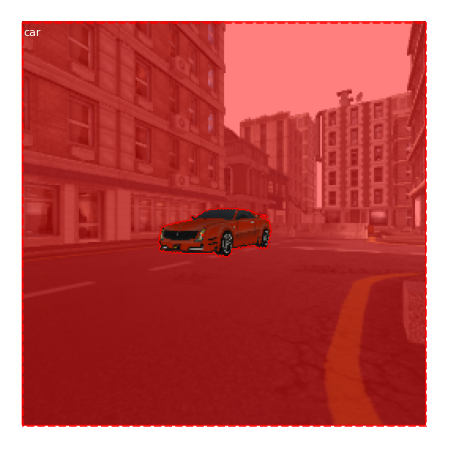

In [33]:
# Test on a random image
import random
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


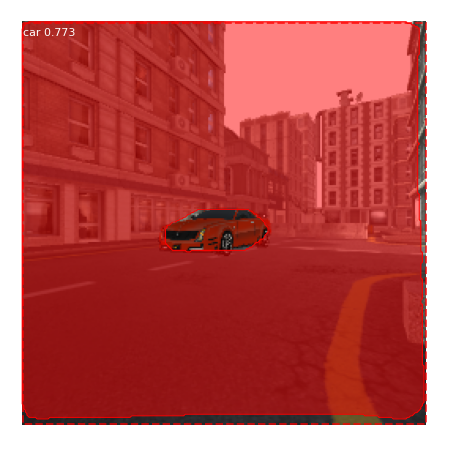

In [34]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [30]:
def viz_test(directory='../../data/test/'):
    '''
    This function loops through a directory predicting against each image and displaying the result.
    '''
    preds = []
    ax = get_ax()
    for i, filename in enumerate(os.listdir(directory)):
        if(os.path.isdir(directory + '/' + filename)):
            continue
        img = Image.open(directory + '/' + filename)
        img = img.resize((256, 256))
        img_as_arr = np.array(img)
        results = model.detect([img_as_arr], verbose=0)
        r = results[0]
        visualize.display_instances(img_as_arr, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax)
        k = input('Hit enter for next image, q to quit')
        if(k == 'q'):
            break
        



*** No instances to display *** 



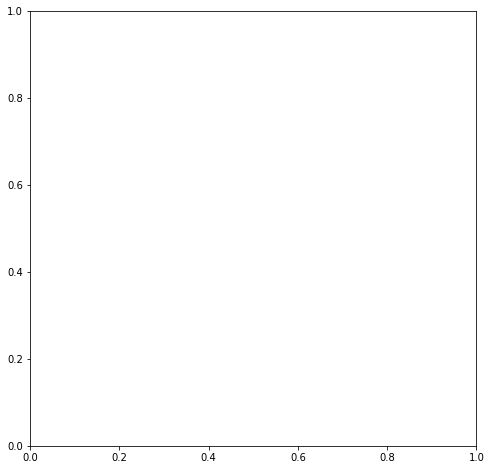

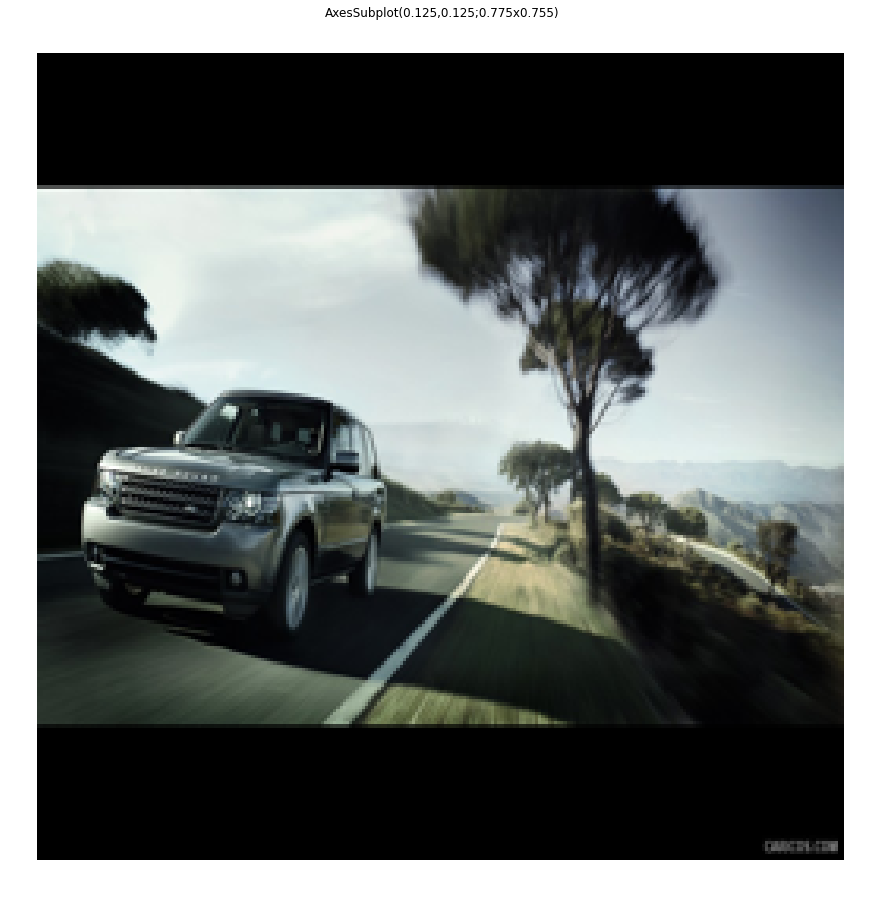

Hit enter for next image, q to quit q


In [35]:
viz_test()